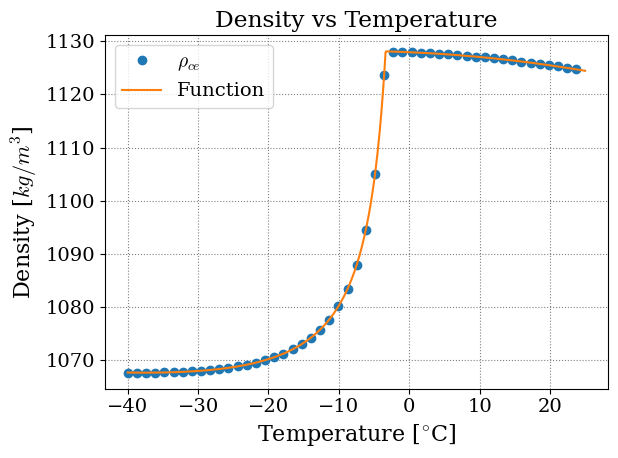

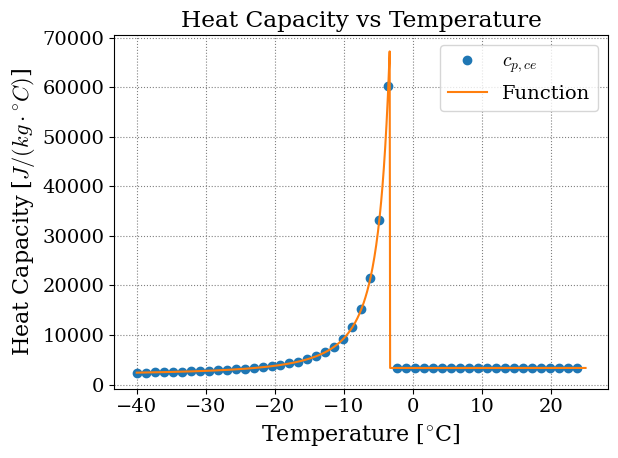

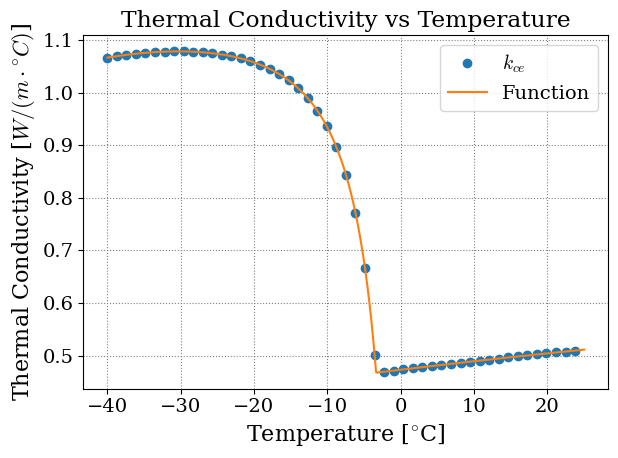

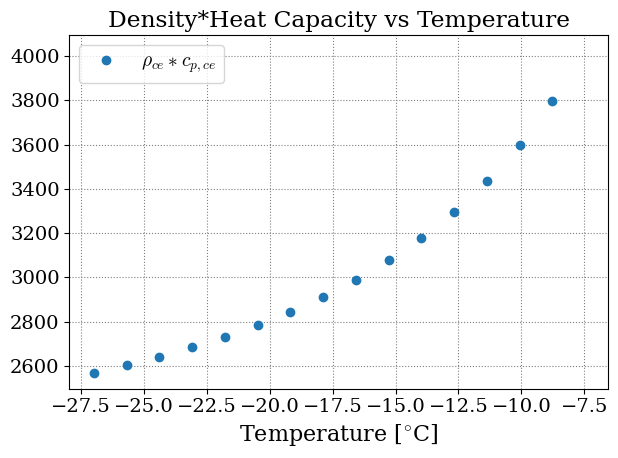

In [ ]:
# =============================================================================
#                                Imports
# =============================================================================
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import UnivariateSpline
from matplotlib import rcParams

# =============================================================================
#                            Global Constants
# =============================================================================
R  = 8.314      # Universal gas constant [J/(mol·K)]
T0 = 273.2      # Reference temperature [K]
Lo = 333.6      # Latent heat of water at T0 [kJ/kg]

# =============================================================================
#                       Composition File Loader
# =============================================================================
def load_composition(filename: str) -> dict:
    """
    Load mixture composition parameters from a JSON file.
    """
    try:
        with open(filename, 'r') as file:
            params = json.load(file)
        return params
    except Exception as e:
        raise RuntimeError(f"Error loading {filename}: {e}")

# =============================================================================
#                     Freezing Temperature Calculator
# =============================================================================
def calculate_T_cong(xs: float) -> float:
    """
    Compute freezing point temperature T_cong based on solute fraction xs.
    """
    return -32.523 * xs**2 - 0.6781 * xs

# =============================================================================
#                  Ice and Liquid Water Fractions
# =============================================================================
def compute_ice_and_water(T: np.ndarray, T_cong: float, humedad: float):
    """
    Vectorized calculation of ice (x_hielo) and liquid water (x_agua) fractions:
      - If T < T_cong: some water freezes.
      - Otherwise: no ice forms.
    """
    x_hielo = np.where(T < T_cong, humedad * (1 - (T_cong / T)), 0)
    x_agua  = humedad - x_hielo
    return x_hielo, x_agua

# =============================================================================
#                          Spline Fitting Utility
# =============================================================================
def spline_fit(x: np.ndarray, y: np.ndarray, x_model: np.ndarray, s: float = 0):
    """
    Fit a UnivariateSpline to (x, y) with smoothing factor s, then evaluate
    it on x_model. Returns (evaluated_values, spline_object).
    """
    spline = UnivariateSpline(x, y, s=s)
    return spline(x_model), spline

# =============================================================================
#                      Density Calculation Function
# =============================================================================
def compute_density(T: np.ndarray, composicion: np.ndarray) -> np.ndarray:
    """
    Compute mixture density via harmonic mean:
      rho_extracto = 1 / sum(w_i / rho_i(T)), where w_i are mass fractions.
    """
    # Component densities as functions of T
    rho_protein       = 1.3299e3 - 5.1840e-1 * T
    rho_lipidos       =   9.2559e2 - 4.1757e-1 * T
    rho_carbohidratos = 1.5991e3 - 3.1046e-1 * T
    rho_fibra         = 1.3115e3 - 3.6589e-1 * T
    rho_cenizas       = 2.4238e3 - 2.8063e-1 * T
    rho_agua          =   9.9718e2 + 3.1439e-3 * T - 3.7574e-3 * T**2
    rho_hielo         =   9.1689e2 - 1.3071e-1 * T

    # Stack into matrix (components × len(T))
    rho_i = np.vstack([
        rho_protein, rho_lipidos, rho_carbohidratos,
        rho_fibra, rho_cenizas, rho_agua, rho_hielo
    ])

    # Inverse weighted sum
    rho_extracto = 1 / np.sum(composicion / rho_i, axis=0)
    return rho_extracto

# =============================================================================
#                Heat Capacity Calculation Function
# =============================================================================
def compute_cp(T: np.ndarray, composicion: np.ndarray,
               xs: float, humedad: float, proteinas: float,
               T_cong: float) -> np.ndarray:
    """
    Compute specific heat capacity Cp:
      - For T < T_cong: uses special formula involving latent heat.
      - For T >= T_cong: weighted sum of component Cp(T).
    """
    # Compute intermediate Ms factor
    xb = 0.4 * proteinas
    Ms = -(xs * R * T0**2) / ((humedad - xb) * Lo * T_cong)

    # Component Cp(T) expressions
    cp_protein       = 2.0082 + 1.2089e-3 * T - 1.3129e-6 * T**2
    cp_lipidos       = 1.9842 + 1.4733e-3 * T - 4.8008e-6 * T**2
    cp_carbohidratos = 1.5488 + 1.9625e-3 * T - 5.9399e-6 * T**2
    cp_fibra         = 1.8459 + 1.8306e-3 * T - 4.4609e-6 * T**2
    cp_cenizas       = 1.0926 + 1.8896e-3 * T - 3.6817e-6 * T**2
    cp_hielo         = 2.0623 + 6.0769e-3 * T
    cp_agua          = np.where(
        T <= 0,
        4.1289 - 5.3062e-3 * T + 9.9516e-4 * T**2,
        4.1289 - 9.0864e-5 * T + 5.4731e-6 * T**2
    )

    # Stack into matrix
    cp_matrix = np.vstack([
        cp_protein, cp_lipidos, cp_carbohidratos,
        cp_fibra, cp_cenizas, cp_agua, cp_hielo
    ])

    # Initialize result
    cp_extracto = np.zeros_like(T)
    mask = T < T_cong

    # Below freezing
    cp_extracto[mask] = (
        1.55 + 1.26 * xs + (xs * R * T0**2) / (Ms * T[mask]**2)
    )
    # Above freezing
    cp_extracto[~mask] = np.sum(
        composicion[:, ~mask] * cp_matrix[:, ~mask], axis=0
    )

    return cp_extracto

# =============================================================================
#                Thermal Conductivity Function
# =============================================================================
def compute_conductivity(T: np.ndarray) -> np.ndarray:
    """
    Return per-component conductivity k_i(T) stacked as a matrix.
    """
    k_protein       = 1.7881e-1 + 1.1958e-3 * T - 2.7178e-6 * T**2
    k_lipidos       = 1.8071e-1 - 2.7604e-4 * T - 1.7749e-7 * T**2
    k_carbohidratos = 2.0141e-1 + 1.3874e-3 * T - 4.3312e-6 * T**2
    k_fibra         = 1.8331e-1 + 1.2497e-3 * T - 3.1683e-6 * T**2
    k_cenizas       = 3.2962e-1 + 1.4011e-3 * T - 2.9069e-6 * T**2
    k_agua          = 5.7109e-1 + 1.7625e-3 * T - 6.7036e-6 * T**2
    k_hielo         = 2.2196    - 6.2489e-3 * T + 1.0154e-4 * T**2

    return np.vstack([
        k_protein, k_lipidos, k_carbohidratos,
        k_fibra, k_cenizas, k_agua, k_hielo
    ])

# =============================================================================
#               Effective Conductivity Mixer
# =============================================================================
def calculate_xk(sustancias: dict) -> dict:
    """
    Iteratively mix conductivities starting from 'agua' as base.
    Returns per-substance volume fraction x and combined k.
    """
    sustancia_base = 'agua'
    rho_base = sustancias[sustancia_base]['rho']
    k_base   = sustancias[sustancia_base]['k']
    x_base   = sustancias[sustancia_base]['content']

    results = {}
    x_total = x_base / rho_base
    k_previous = k_base

    for sust, props in sustancias.items():
        if sust == sustancia_base:
            continue
        rho_curr    = props['rho']
        k_curr      = props['k']
        content_curr= props['content']

        x_curr  = content_curr / rho_curr
        x_total += x_curr
        x_factor = x_curr / x_total

        # Mixing formula
        k_combined = k_previous * (
            k_curr + 2*k_previous - 2*x_factor*(k_previous - k_curr)
        ) / (k_curr + 2*k_previous + x_factor*(k_previous - k_curr))

        k_previous = k_combined
        results[sust] = {'x': x_factor, 'k': k_combined}

    return results

# =============================================================================
#                       Plotting Function
# =============================================================================
def plot_properties(T: np.ndarray, T_model: np.ndarray,
                    rho_extract: np.ndarray, func_rho: np.ndarray,
                    cp_extract: np.ndarray, func_cp: np.ndarray,
                    k_extract: np.ndarray, func_k: np.ndarray):
    """
    Plot and save PDFs for:
      - Density vs T
      - Heat Capacity vs T
      - Thermal Conductivity vs T
      - (ρ·Cp) vs T over a subset
    """
    # Density plot
    fig, ax = plt.subplots()
    plt.title('Density vs Temperature')
    plt.plot(T, rho_extract, 'o', label=r"$\rho_{ce}$", markevery=20)
    plt.plot(T_model, func_rho, label='Function')
    plt.xlabel(r'Temperature [$^{\circ}$C]')
    plt.ylabel(r'Density [kg/m^3]')
    plt.legend()
    ax.grid(which='major', linestyle=':', color='gray')
    plt.tight_layout()
    plt.savefig("densidadvsT.pdf", format="pdf", bbox_inches="tight")

    # Heat capacity plot
    fig, ax = plt.subplots()
    plt.title('Heat Capacity vs Temperature')
    plt.plot(T, cp_extract*1000, 'o', label='$c_{p,ce}$', markevery=20)
    plt.plot(T_model, func_cp*1000, label='Function')
    plt.xlabel(r'Temperature [$^{\circ}$C]')
    plt.ylabel(r'Heat Capacity [J/(kg·K)]')
    plt.legend()
    ax.grid(which='major', linestyle=':', color='gray')
    plt.tight_layout()
    plt.savefig("heatCapvsT.pdf", format="pdf", bbox_inches="tight")

    # Conductivity plot
    fig, ax = plt.subplots()
    plt.title('Thermal Conductivity vs Temperature')
    plt.plot(T, k_extract, 'o', label='$k_{ce}$', markevery=20)
    plt.plot(T_model, func_k, label='Function')
    plt.xlabel(r'Temperature [$^{\circ}$C]')
    plt.ylabel(r'Thermal Conductivity [W/(m·K)]')
    plt.legend()
    ax.grid(which='major', linestyle=':', color='gray')
    plt.tight_layout()
    plt.savefig("conductivsT.pdf", format="pdf", bbox_inches="tight")

    # ρ·Cp subset plot
    fig, ax = plt.subplots()
    plt.title(r'$\rho \cdot c_p$ vs Temperature')
    plt.plot(
        T[200:500],
        rho_extract[200:500] * cp_extract[200:500],
        'o', label=r"$\rho_{ce}\,c_{p,ce}$", markevery=20
    )
    plt.xlabel(r'Temperature [$^{\circ}$C]')
    plt.legend()
    ax.grid(which='major', linestyle=':', color='gray')
    plt.tight_layout()
    plt.savefig("rho_cp_vsT.pdf", format="pdf", bbox_inches="tight")
    plt.show()

# =============================================================================
#                              Main Script
# =============================================================================
if __name__ == "__main__":
    # Matplotlib style
    rcParams['font.family']      = 'serif'
    rcParams['font.size']        = 14
    rcParams['legend.fontsize']  = 14
    rcParams['mathtext.fontset'] = 'cm'
    rcParams['axes.labelsize']   = 16

    # Load composition parameters
    params = load_composition('compo.txt')
    xs            = params['xs']
    humedad       = params['humedad']
    fibra         = params['fibra']
    lipidos       = params['lipidos']
    cenizas       = params['cenizas']
    proteinas     = params['proteinas']
    carbohidratos = params['carbohidratos']

    # Temperature vectors and freezing point
    T       = np.linspace(-40, 25, 1000)
    T_cong  = calculate_T_cong(xs)
    T_model = np.linspace(-40, 25, 1000)

    # Compute ice and water fractions
    x_hielo, x_agua = compute_ice_and_water(T, T_cong, humedad)

    # Build composition matrix
    composicion = np.vstack([
        proteinas      * np.ones_like(T),
        lipidos        * np.ones_like(T),
        carbohidratos  * np.ones_like(T),
        fibra          * np.ones_like(T),
        cenizas        * np.ones_like(T),
        x_agua,
        x_hielo
    ])

    # Calculate density
    rho_extracto = compute_density(T, composicion)

    # Spline fits for density below/above freezing
    mask_menor = T <= T_cong
    mask_mayor = T >= T_cong
    func_rho_menor, _ = spline_fit(
        T[mask_menor], rho_extracto[mask_menor],
        x_model=T_model[mask_menor], s=0
    )
    func_rho_mayor, _ = spline_fit(
        T[mask_mayor], rho_extracto[mask_mayor],
        x_model=T_model[mask_mayor], s=0
    )
    func_rho = np.concatenate([func_rho_menor, func_rho_mayor])

    # Calculate heat capacity and spline fits
    cp_extracto, _ = compute_cp(T, composicion, xs, humedad, proteinas, T_cong), None
    func_cp_menor, _ = spline_fit(
        T[mask_menor], cp_extracto[mask_menor],
        x_model=T_model[mask_menor], s=0
    )
    func_cp_mayor, _ = spline_fit(
        T[mask_mayor], cp_extracto[mask_mayor],
        x_model=T_model[mask_mayor], s=0
    )
    func_cp = np.concatenate([func_cp_menor, func_cp_mayor])

    # Compute component conductivities
    k_i = compute_conductivity(T)
    sustancias = {
        "agua": {
            "rho": 9.9718e2 + 3.1439e-3 * T - 3.7574e-3 * T**2,
            "k":   5.7109e-1 + 1.7625e-3 * T - 6.7036e-6 * T**2,
            "content": x_agua
        },
        "fibra": {
            "rho": 1.3115e3 - 3.6589e-1 * T,
            "k":   1.8331e-1 + 1.2497e-3 * T - 3.1683e-6 * T**2,
            "content": fibra
        },
        "lipidos": {
            "rho": 9.2559e2 - 4.1757e-1 * T,
            "k":   1.8071e-1 - 2.7604e-4 * T - 1.7749e-7 * T**2,
            "content": lipidos
        },
        "cenizas": {
            "rho": 2.4238e3 - 2.8063e-1 * T,
            "k":   3.2962e-1 + 1.4011e-3 * T - 2.9069e-6 * T**2,
            "content": cenizas
        },
        "proteinas": {
            "rho": 1.3299e3 - 5.1840e-1 * T,
            "k":   1.7881e-1 + 1.1958e-3 * T - 2.7178e-6 * T**2,
            "content": proteinas
        },
        "carbohidratos": {
            "rho": 1.5991e3 - 3.1046e-1 * T,
            "k":   2.0141e-1 + 1.3874e-3 * T - 4.3312e-6 * T**2,
            "content": carbohidratos
        },
        "hielo": {
            "rho": 9.1689e2 - 1.3071e-1 * T,
            "k":   2.2196    - 6.2489e-3 * T + 1.0154e-4 * T**2,
            "content": x_hielo
        }
    }

    # Mix conductivities and extract final k_extracto
    resultados   = calculate_xk(sustancias)
    k_extracto   = resultados['hielo']['k']

    # Spline fits for conductivity
    func_k_menor, _ = spline_fit(
        T[mask_menor], k_extracto[mask_menor],
        x_model=T_model[mask_menor], s=0
    )
    func_k_mayor, _ = spline_fit(
        T[mask_mayor], k_extracto[mask_mayor],
        x_model=T_model[mask_mayor], s=0
    )
    func_k = np.concatenate([func_k_menor, func_k_mayor])

    # Generate and save plots of all properties
    plot_properties(T, T_model, rho_extracto, func_rho,
                    cp_extracto, func_cp, k_extracto, func_k)

    
    

         0      1     2
0     0.00      0  22.5
1     0.25    900  21.2
2     0.50   1800  14.9
3     0.75   2700  13.9
4     1.00   3600  10.5
..     ...    ...   ...
96   24.00  86400 -20.0
97   24.25  87300 -20.0
98   24.50  88200 -20.0
99   24.75  89100 -20.0
100  25.00  90000 -20.0

[101 rows x 3 columns]


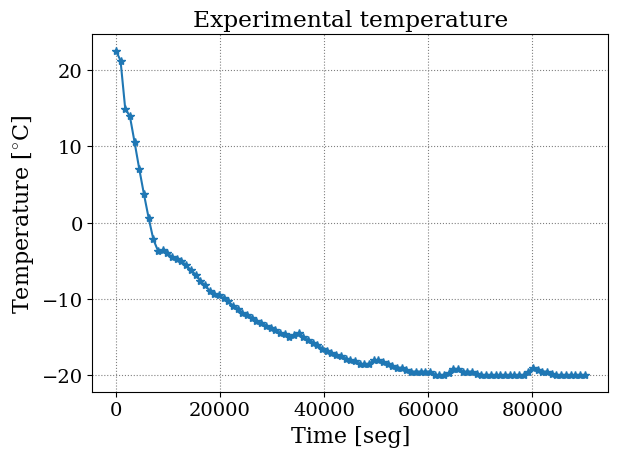

<Figure size 640x480 with 0 Axes>

In [ ]:

# =============================================================================
#                Read and Plot Experimental Temperature Data
# =============================================================================
import pandas as pd
import matplotlib.pyplot as plt

# Load the experimental data CSV (semicolon-delimited, no header row)
resultados = pd.read_csv(
    "FCS_experimental_peq.csv",
    delimiter=";",
    header=None
)

# Display the raw data for inspection
print(resultados)

# Create a new figure and axis for plotting
fig, ax = plt.subplots()

# Set the plot title
plt.title('Experimental Temperature')

# Plot temperature vs. time:
#   - Column 0 is time in hours; multiply by 3600 to convert to seconds
#   - Last column contains the temperature values
plt.plot(
    resultados.iloc[:, 0] * 3600,   # x values: time [s]
    resultados.iloc[:, -1],         # y values: temperature [°C]
    '-*',                           # line style with star markers
    markevery=1                     # plot every data point marker
)

# Label the axes
plt.xlabel(r'Time [seg]')
plt.ylabel(r'Temperature [$^{\circ}$C]$')

# Add a grid for better readability
ax.grid(which='major', axis='both', linestyle=':', color='gray')

# Adjust layout to prevent clipping of labels/legend
plt.tight_layout()

# Display the plot on screen
plt.show()

# Save the figure as a PDF
plt.savefig(
    "Texperimental.pdf",
    format="pdf",
    bbox_inches="tight"
)


             0     1
0     0.000000  20.0
1     0.083333  20.0
2     0.166667  11.2
3     0.250000   9.2
4     0.333333   9.2
..         ...   ...
295  24.583333  -4.5
296  24.666667  -4.5
297  24.750000  -4.5
298  24.833333  -4.5
299  24.916667  -4.5

[300 rows x 2 columns]


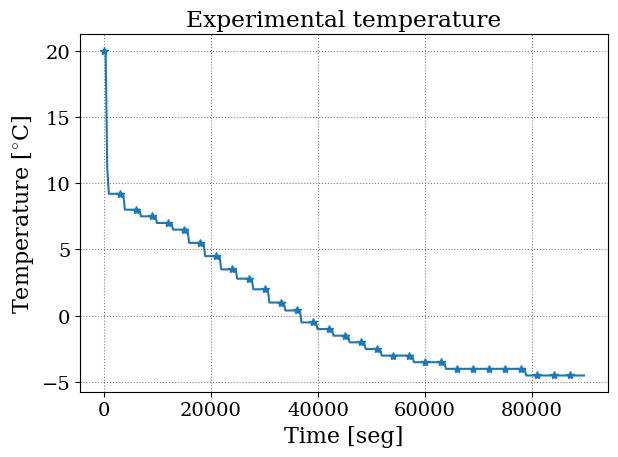

<Figure size 640x480 with 0 Axes>

In [ ]:
# =============================================================================
#                                Imports
# =============================================================================
import pandas as pd
import matplotlib.pyplot as plt

# =============================================================================
#                         Load and Clean Excel Data
# =============================================================================
# Path to the Excel file containing model temperatures
file_path = "T_model_big.xlsx"

# Read all data as strings to handle comma decimals safely
df = pd.read_excel(file_path, dtype=str)

# Replace commas with dots and convert to numeric, coercing errors to NaN
df = (
    df
    .apply(lambda col: col.str.replace(',', '.'))  # swap decimal comma → point
    .apply(pd.to_numeric, errors='coerce')         # convert to numbers
)

# =============================================================================
#                      Filter by Temperature Threshold
# =============================================================================
# Keep only rows where the first column (temperature) is <= 25 °C
df_filtered = df[df.iloc[:, 0] <= 25]

# =============================================================================
#                        Save Filtered Data to CSV
# =============================================================================
output_path = "T_model_big.csv"
df_filtered.to_csv(
    output_path,
    sep=";",      # semicolon delimiter
    index=False   # do not write row indices
)

# =============================================================================
#                         Load CSV for Plotting
# =============================================================================
# Read back the saved CSV without header
T_exact = pd.read_csv(output_path, delimiter=";", header=None)

# Display the loaded data (for verification)
print(T_exact)

# =============================================================================
#                          Plot Experimental Data
# =============================================================================
fig, ax = plt.subplots()

# Plot temperature vs. time
#   - Column 0: time in hours → convert to seconds by multiplying by 3600
#   - Last column: temperature in °C
ax.plot(
    T_exact.iloc[:, 0] * 3600,
    T_exact.iloc[:, -1],
    '-*',
    markevery=10
)

# Title and axis labels
ax.set_title('Experimental Temperature')
ax.set_xlabel(r'Time [seg]')
ax.set_ylabel(r'Temperature [$^{\circ}$C]$')

# Grid and layout adjustments
ax.grid(which='major', axis='both', linestyle=':', color='gray')
plt.tight_layout()

# Display and save the figure
plt.show()
plt.savefig(
    "Texperimental.pdf",
    format="pdf",
    bbox_inches="tight"
)


             0     1
0     0.000000  20.0
1     0.050000  19.5
2     0.133333  16.2
3     0.216667  16.0
4     0.300000  15.5
..         ...   ...
296  24.633333 -17.3
297  24.716667 -17.3
298  24.800000 -17.3
299  24.883333 -17.3
300  24.966667 -17.3

[301 rows x 2 columns]


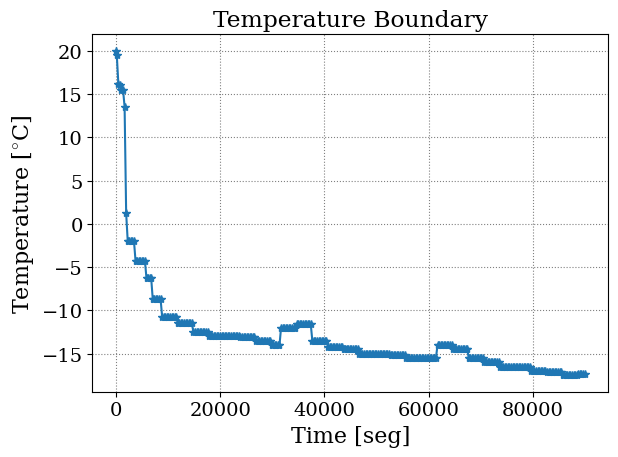

<Figure size 640x480 with 0 Axes>

In [ ]:
# =============================================================================
#                                Imports
# =============================================================================
import pandas as pd
import matplotlib.pyplot as plt

# =============================================================================
#                      Load and Clean Excel Data
# =============================================================================
# Path to the Excel file containing boundary-condition temperatures
file_path = "T_model_BC.xlsx"

# Read all data as strings to handle comma decimals safely
df = pd.read_excel(file_path, dtype=str)

# Replace commas with dots and convert to numeric, coercing invalid parsing to NaN
df = (
    df
    .apply(lambda col: col.str.replace(',', '.'))  # swap decimal commas → points
    .apply(pd.to_numeric, errors='coerce')         # convert to floats
)

# =============================================================================
#                      Filter by Temperature Threshold
# =============================================================================
# Keep only rows where the first column (temperature) is <= 25 °C
df_filtered = df[df.iloc[:, 0] <= 25]

# =============================================================================
#                        Save Filtered Data to CSV
# =============================================================================
output_path = "T_model_BC.csv"
df_filtered.to_csv(
    output_path,
    sep=";",      # use semicolon delimiter
    index=False   # omit row indices
)

# =============================================================================
#                         Load CSV for Plotting
# =============================================================================
# Read back the saved CSV without header
T_BC = pd.read_csv(output_path, delimiter=";", header=None)

# Display the loaded data (for verification)
print(T_BC)

# =============================================================================
#                          Plot Boundary Temperature
# =============================================================================
fig, ax = plt.subplots()

# Plot temperature vs. time:
#   - Column 0: time in hours → convert to seconds by multiplying by 3600
#   - Last column: boundary-condition temperature in °C
ax.plot(
    T_BC.iloc[:, 0] * 3600,
    T_BC.iloc[:, -1],
    '-*'
)

# Set title and axis labels
ax.set_title('Temperature Boundary')
ax.set_xlabel(r'Time [seg]')
ax.set_ylabel(r'Temperature [$^{\circ}$C]$')

# Add grid lines for clarity
ax.grid(which='major', axis='both', linestyle=':', color='gray')

# Adjust layout to prevent clipping
plt.tight_layout()

# Display and save the figure
plt.show()
plt.savefig(
    "T_BC.pdf",
    format="pdf",
    bbox_inches="tight"
)


In [ ]:
# =============================================================================
#                                Imports
# =============================================================================
import numpy as np

# =============================================================================
#                 Save Thermophysical Properties to CSV
# =============================================================================
# Stack columns: 
#   T_model     → nondimensional/model temperature vector
#   func_rho    → fitted density function values
#   func_cp*1000→ fitted heat capacity (J/kg·°C), multiplied by 1000 to convert
#   func_k      → fitted conductivity values
data = np.column_stack((T_model, func_rho, func_cp * 1000, func_k))

# Write to 'properties_data.csv' with a header row (no comment prefix)
np.savetxt(
    "properties_data.csv",
    data,
    delimiter=",",
    header="T_model,func_rho,func_cp,func_k",
    comments=""
)

# =============================================================================
#               Save Boundary-Condition Data to CSV
# =============================================================================
# Stack columns:
#   Time in seconds (hours → seconds) from T_BC DataFrame
#   Temperature boundary-condition values
boundary_time = T_BC.iloc[:, 0] * 3600
boundary_temp = T_BC.iloc[:, -1]
data = np.column_stack((boundary_time, boundary_temp))

# Write to 'data_boundary.csv'
np.savetxt(
    "data_boundary.csv",
    data,
    delimiter=",",
    header="times,Temp_BC",
    comments=""
)

# =============================================================================
#                 Save Experimental Model Data to CSV
# =============================================================================
# Stack columns:
#   Time in seconds from T_exact DataFrame
#   Experimental/model temperature values
model_time = T_exact.iloc[:, 0] * 3600
model_temp = T_exact.iloc[:, -1]
data = np.column_stack((model_time, model_temp))

# Write to 'data_model.csv'
np.savetxt(
    "data_model.csv",
    data,
    delimiter=",",
    header="times,Temp_model",
    comments=""
)



2025-03-18 14:07:19.634740: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.17.0


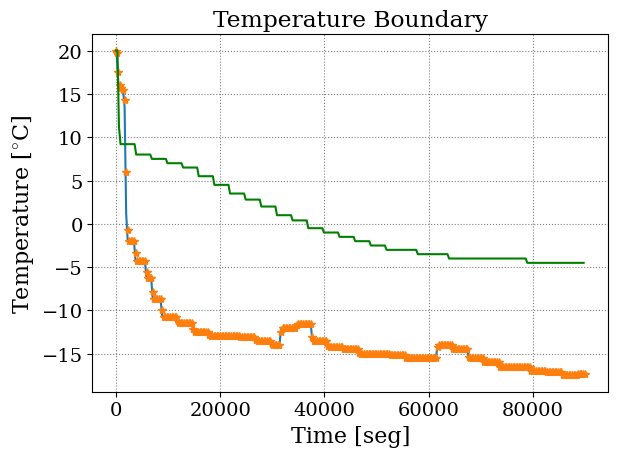

<Figure size 640x480 with 0 Axes>

In [ ]:
# =============================================================================
#                                Imports
# =============================================================================
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

# =============================================================================
#                      Check TensorFlow Version
# =============================================================================
# Print the installed TensorFlow version
print("TensorFlow version:", tf.__version__)

# =============================================================================
#              Interpolate Boundary-Condition Temperature
# =============================================================================
# Use TensorFlow Probability to perform regular 1D interpolation of
# the boundary-condition data (T_BC DataFrame).
#   - x: Time values [s] from the first column of T_BC
#   - x_start: Minimum time
#   - x_end: Maximum time
#   - y: Boundary temperatures from last column of T_BC
TB_interp = tfp.math.interp_regular_1d_grid(
    T_BC.iloc[:, 0] * 3600,
    min(T_BC.iloc[:, 0] * 3600),
    max(T_BC.iloc[:, 0] * 3600),
    T_BC.iloc[:, -1]
)

# =============================================================================
#                      Plot Boundary & Model Temperatures
# =============================================================================
fig, ax = plt.subplots()

# Title and axis labels
plt.title('Temperature Boundary')
plt.xlabel(r'Time [seg]')
plt.ylabel(r'Temperature [$^{\circ}$C]$')

# Plot raw boundary data
plt.plot(
    T_BC.iloc[:, 0] * 3600,
    T_BC.iloc[:, -1],
    label='Boundary data'
)

# Plot interpolated boundary-condition temperature
plt.plot(
    T_BC.iloc[:, 0] * 3600,
    TB_interp,
    '*',
    label='Interpolated BC'
)

# Plot exact/model temperature for comparison
plt.plot(
    T_exact.iloc[:, 0] * 3600,
    T_exact.iloc[:, -1],
    'g',
    label='Model data'
)

# Add grid, legend, and tidy up layout
ax.grid(which='major', axis='both', linestyle=':', color='gray')
plt.legend()
plt.tight_layout()

# Display and save the figure
plt.show()
plt.savefig("T_BC.pdf", format="pdf", bbox_inches="tight")
